In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from collections import Counter

from sklearn import preprocessing as sk_preprocessing
import re
from tensorflow.keras import preprocessing as t_preprocessing
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


matplotlib.style.use('ggplot')

In [2]:
sms_data_path = r'datasets/sms-spam-collection/spam.csv'

In [3]:
sms_df = pd.read_csv(sms_data_path, engine='python')

In [4]:
sms_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
x, y = sms_df['v2'].values, sms_df['v1'].values

In [6]:
sms_lengths = list(map(lambda x: len(x), x))

In [7]:
# Longest sms message
print(x[np.argmax(sms_lengths)])

For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don&#39;t have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..


In [8]:
sms = x[0]

In [9]:
sms

&#39;Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...&#39;

In [10]:
all_words = [word.lower() for sms in x for word in re.findall(r"[\w']+",sms)]

In [12]:
word_count = Counter(all_words)
word_count_sorted = word_count.most_common()

num_words = len(word_count_sorted)

Text(0, 0.5, &#39;Number of words with such occurence&#39;)

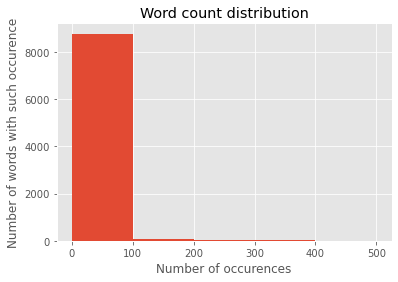

In [13]:
plt.hist(word_count.values(), bins=5, range=(0, 500))
plt.title('Word count distribution')
plt.xlabel('Number of occurences')
plt.ylabel('Number of words with such occurence')

In [14]:
num_words

8910

In [15]:
# let us take 8000 most common words and create dict out of them
word_count_sorted = word_count_sorted[:7998]

In [33]:
word_encoding = { word_count_pair[0]: i for i, word_count_pair in enumerate(word_count_sorted, start=1) }
word_decoding = dict(zip(word_encoding.values(), word_encoding.keys()))

missing_word_code = max(word_encoding.values())+1
word_encoding['missing_word'] = missing_word_code
word_decoding[missing_word_code] = 'missing_word'

In [34]:
# encode dataset

x_encoded = []

for sms in x:
    sms_words = re.findall(r"[\w']+", sms)
    sms_encoded = [word_encoding[word] if word in word_encoding.keys() else missing_word_code for word in sms_words]
    x_encoded.append(sms_encoded)

In [35]:
def encode_sms(decoded_sms):
    encoded_sms = [word_encoding[word] if word in decoded_sms else word_encoding['missing_word'] for word in decoded_sms]
    return encoded_sms

def decode_sms(encoded_sms):
    decoded_sms = [word_decoding[code] for code in encoded_sms]
    return decoded_sms

In [36]:
assert x_encoded[0] == encode_sms(decode_sms(x_encoded[0])), "Codes do not match!"

In [57]:

MAXLEN = 100

In [38]:
x_encoded_padded = t_preprocessing.sequence.pad_sequences(x_encoded, MAXLEN)

x_encoded_padded = np.array(x_encoded_padded)

In [39]:
x_encoded_padded.shape

(5572, 100)

In [40]:
lengths_padded = set(map(lambda x: len(x), x_encoded_padded))

In [41]:
lengths_padded

{100}

In [60]:
label_encoder = sk_preprocessing.LabelEncoder()
labels = label_encoder.fit_transform(y)

In [61]:
label_encoder.classes_

array([&#39;ham&#39;, &#39;spam&#39;], dtype=object)

In [62]:


NUM_WORDS = 8000



In [63]:
X_train, X_test, y_train, y_test = train_test_split(x_encoded_padded, labels, stratify=labels, test_size=0.2, random_state=1)

In [125]:
def simple_lstm_model():
    model = Sequential()
    model.add(layers.Embedding(NUM_WORDS, 16, input_length=MAXLEN))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [88]:
model = simple_lstm_model()
model.summary()

Model: &quot;sequential_3&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           128000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 142,977
Trainable params: 142,977
Non-trainable params: 0
_________________________________________________________________


In [89]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
112/112 [==============================] - 1s 10ms/step - loss: 0.2744 - accuracy: 0.8985 - val_loss: 0.1558 - val_accuracy: 0.9652
Epoch 2/10
112/112 [==============================] - 1s 8ms/step - loss: 0.1069 - accuracy: 0.9644 - val_loss: 0.0621 - val_accuracy: 0.9765
Epoch 3/10
112/112 [==============================] - 1s 7ms/step - loss: 0.0528 - accuracy: 0.9854 - val_loss: 0.0514 - val_accuracy: 0.9821
Epoch 4/10
112/112 [==============================] - 1s 8ms/step - loss: 0.0385 - accuracy: 0.9902 - val_loss: 0.0490 - val_accuracy: 0.9843
Epoch 5/10
112/112 [==============================] - 1s 7ms/step - loss: 0.0338 - accuracy: 0.9902 - val_loss: 0.0531 - val_accuracy: 0.9843
Epoch 6/10
112/112 [==============================] - 1s 7ms/step - loss: 0.0278 - accuracy: 0.9927 - val_loss: 0.0602 - val_accuracy: 0.9821
Epoch 7/10
112/112 [==============================] - 1s 7ms/step - loss: 0.0221 - accuracy: 0.9938 - val_loss: 0.0798 - val_accuracy: 0.9765
Epoch

In [179]:
model.evaluate(X_test, y_test)

35/35 [==============================] - 0s 3ms/step - loss: 0.0811 - accuracy: 0.9794


[0.08109329640865326, 0.9793722033500671]

In [91]:
mail_spam_csv = pd.read_csv(r'datasets\mail-spam-collection\spam_ham_dataset.csv')

In [92]:
mail_spam_csv.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [93]:
x_spam, y_spam = mail_spam_csv['text'].values, mail_spam_csv['label_num'].values

In [94]:
x_spam.shape

(5171,)

In [95]:
y_spam.shape

(5171,)

In [161]:
x_spam_encoded = list()

for mail in x_spam:
    mail_words = re.findall(r"[\w']+", mail)
    mail_encoded = [word_encoding[word] if word in word_encoding.keys() else missing_word_code for word in mail_words]
    x_spam_encoded.append(mail_encoded)

In [162]:
x_spam_padded = t_preprocessing.sequence.pad_sequences(x_spam_encoded, MAXLEN)

In [180]:
model.evaluate(x_spam_padded, y_spam)

162/162 [==============================] - 1s 4ms/step - loss: 2.6695 - accuracy: 0.6326


[2.66947078704834, 0.6325662136077881]

In [168]:
from collections import Counter

In [169]:
c = Counter(y_spam)

In [170]:
c

Counter({0: 3672, 1: 1499})

In [171]:
# we have data mismatch, let us again train the network on union of train sets

In [172]:
X_mail_train, X_mail_test, y_mail_train, y_mail_test = train_test_split(x_spam_padded, y_spam, stratify=y_spam, test_size=0.2, random_state=1)

In [184]:
Xtr, ytr = np.vstack([X_train, X_mail_train]), np.hstack([y_train, y_mail_train])
Xte, yte = np.vstack([X_test, X_mail_test]), np.hstack([y_test, y_mail_test])

In [185]:
model2 = simple_lstm_model()
model2.summary()

Model: &quot;sequential_13&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 16)           128000    
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_26 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 257       
Total params: 142,977
Trainable params: 142,977
Non-trainable params: 0
_________________________________________________________________


In [186]:
neg, pos = np.bincount(y_mail_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

Examples:
    Total: 4136
    Positive: 1199 (28.99% of total)



In [187]:
X_mail_train[98]

array([7999, 7816, 7999, 7999, 7455, 3731, 7999, 7870, 7999, 7999, 7999,
       7999, 3845, 3566, 7999, 3619, 7999, 7999, 7999, 7999, 7999, 7999,
       4689, 5137, 7999, 7999, 7999, 7999, 7999, 7999, 7999, 7999, 7999,
       7999, 7999, 7999, 7999, 7999, 7999, 7999, 7999,   51, 7999, 7878,
       7999, 3546, 7999, 7999, 7999, 1320, 7999, 7999, 7999, 1229, 2657,
        894,    8, 7999,    8, 7999,   36, 7999, 7999, 7999,  799,  187,
        299,  935, 7999, 5382, 4689, 5137, 7999, 7999, 5646, 7999, 7999,
        799,  187, 7999,    2, 2841,  883,    5, 4689, 7999, 7999, 7999,
       1229,    5, 1229, 7999, 3719,   12, 7999, 7999, 7999,  507,   51,
       7455])

In [188]:
history = model2.fit(X_mail_train, y_mail_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight)

Epoch 1/10
104/104 [==============================] - 1s 10ms/step - loss: 0.4281 - accuracy: 0.7869 - val_loss: 0.1704 - val_accuracy: 0.9384
Epoch 2/10
104/104 [==============================] - 1s 7ms/step - loss: 0.1446 - accuracy: 0.9423 - val_loss: 0.1073 - val_accuracy: 0.9638
Epoch 3/10
104/104 [==============================] - 1s 8ms/step - loss: 0.0875 - accuracy: 0.9674 - val_loss: 0.0823 - val_accuracy: 0.9662
Epoch 4/10
104/104 [==============================] - 1s 8ms/step - loss: 0.0652 - accuracy: 0.9770 - val_loss: 0.0941 - val_accuracy: 0.9674
Epoch 5/10
104/104 [==============================] - 1s 8ms/step - loss: 0.0466 - accuracy: 0.9837 - val_loss: 0.0952 - val_accuracy: 0.9674
Epoch 6/10
104/104 [==============================] - 1s 7ms/step - loss: 0.0383 - accuracy: 0.9879 - val_loss: 0.1170 - val_accuracy: 0.9601
Epoch 7/10
104/104 [==============================] - 1s 7ms/step - loss: 0.0216 - accuracy: 0.9924 - val_loss: 0.1332 - val_accuracy: 0.9722
Epoch

In [189]:
model2.evaluate(X_mail_test, y_mail_test)

33/33 [==============================] - 0s 4ms/step - loss: 0.2065 - accuracy: 0.9739


[0.20649106800556183, 0.9739130139350891]

In [190]:
model3 = simple_lstm_model()
model3.summary()

Model: &quot;sequential_14&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 16)           128000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_28 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 142,977
Trainable params: 142,977
Non-trainable params: 0
_________________________________________________________________


In [191]:
history = model3.fit(Xtr, ytr, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
215/215 [==============================] - 2s 9ms/step - loss: 0.2972 - accuracy: 0.8819 - val_loss: 0.3020 - val_accuracy: 0.8802
Epoch 2/10
215/215 [==============================] - 2s 7ms/step - loss: 0.1534 - accuracy: 0.9475 - val_loss: 0.2505 - val_accuracy: 0.9069
Epoch 3/10
215/215 [==============================] - 2s 7ms/step - loss: 0.1153 - accuracy: 0.9601 - val_loss: 0.2741 - val_accuracy: 0.9116
Epoch 4/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0926 - accuracy: 0.9699 - val_loss: 0.2749 - val_accuracy: 0.9168
Epoch 5/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0825 - accuracy: 0.9713 - val_loss: 0.2668 - val_accuracy: 0.9122
Epoch 6/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0728 - accuracy: 0.9757 - val_loss: 0.2413 - val_accuracy: 0.9191
Epoch 7/10
215/215 [==============================] - 2s 7ms/step - loss: 0.0668 - accuracy: 0.9785 - val_loss: 0.2297 - val_accuracy: 0.9232
Epoch 

In [192]:
model3.evaluate(Xte, yte)

68/68 [==============================] - 0s 3ms/step - loss: 0.1947 - accuracy: 0.9456


[0.19468116760253906, 0.9455813765525818]

In [112]:
X_train.shape

(4457, 100)

In [108]:
X_mail_train.shape

(4136, 100)

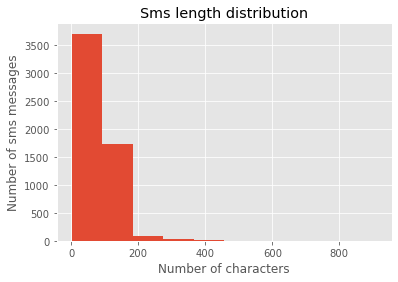

In [41]:
plt.hist(sms_lengths, bins=10)
plt.title('Sms length distribution')
plt.ylabel('Number of sms messages')
plt.xlabel('Number of characters')
plt.show()
